# NB3 - Analyse Benchmarking Results

## 1. Import Libraries and Load Data


In [2]:
import pandas as pd
import os
import csv
import sys
print(os.getcwd())

csv.field_size_limit(sys.maxsize)
df = pd.read_csv('../data/longbench_results.csv', delimiter='§', engine="python")
df.head()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
/Users/marym/Documents/Programming/Python/ST311/ST311_group_project/notebooks


,_id,domain,sub_domain,difficulty,length,question,choice_A,choice_B,choice_C,choice_D,...,context_tokens,within_context_window,llm_answer_simple,input_tokens_simple,llm_answer_sentence,input_tokens_sentence,llm_answer_asc,input_tokens_asc,llm_answer_lc,input_tokens_lc
0,66f36490821e116aacb2cc22,Single-Document QA,Financial,easy,short,"According to the report, how to promote the co...","Through technology empowerment, change the way...","Establish new types of courts, such as intelle...",Improve the work ability of office staff and s...,Use advanced information systems to improve th...,...,38133,True,A,3262,D,2145,A,2822,A,35327
1,66ebed525a08c7b9b35e1cb4,Single-Document QA,Academic,hard,short,"When Miller tried to answer the question ""shou...",Each must read for himself or herself and test...,Readers must reach a high standrad to some deg...,"It is the readers' obligation to get the ""trut...",The performative interpretation of language tr...,...,24007,True,B,2991,A,2582,A,2149,B,25610
2,671b3cabbb02136c067d5252,Long-dialogue History Understanding,Agent history QA,hard,short,Which player got the least utility in the game?,player_1,player_3,player_5,player_7,...,43168,True,A,2549,C,2323,B,47185,B,47177
3,66ec0c4c821e116aacb1994a,Multi-Document QA,Academic,easy,medium,Which of the following statements is correct?,Both contractor data and data crawled from the...,All machine learning methods involved in the t...,Both voyager and VPT control Minecraft agents ...,VPT's modeling of action space is approximate ...,...,67185,True,A,2881,A,2462,A,2012,B,66821
4,66f920d8bb02136c067c4b81,Single-Document QA,Literary,hard,medium,What is mainly symbolized by the frequent chol...,Confusion of The Times,The impermanence of the character's fate,Love is dangerous and uncontrollable,Social indifference,...,85218,True,C,2855,C,2825,B,3329,D,95095


## 2. Overall Accuracy by Method

In [3]:
print(df.columns.tolist()) 
df.head()  
print(df["answer"].head(10))

['_id', 'domain', 'sub_domain', 'difficulty', 'length', 'question', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'answer', 'context', 'context_tokens', 'within_context_window', 'llm_answer_simple', 'input_tokens_simple', 'llm_answer_sentence', 'input_tokens_sentence', 'llm_answer_asc', 'input_tokens_asc', 'llm_answer_lc', 'input_tokens_lc']
0    D
1    B
2    B
3    D
4    C
5    D
6    A
7    A
8    B
9    B
Name: answer, dtype: object


In [4]:
# Build columns to indicate whether each method generate the correct answer (compare to column "answer")
methods = ["llm_answer_simple", "llm_answer_sentence", "llm_answer_asc", "llm_answer_lc"]

for method in methods:
    df[f"y_or_n_{method}"] = df[method] == df["answer"]

# Define "accuracy" as the no. of correct answers divided by the total no. of answers
accuracy = {
    method: df[f"y_or_n_{method}"].mean()
    for method in methods
}

accuracy_df = pd.DataFrame.from_dict(accuracy, orient="index", columns=["accuracy"])
accuracy_df = accuracy_df.sort_values(by="accuracy", ascending=False)
display(accuracy_df)


,accuracy
llm_answer_lc,0.438944
llm_answer_simple,0.422442
llm_answer_asc,0.422442
llm_answer_sentence,0.386139


## 3. Token Usage Comparison: Long-context vs RAG (Average)

In [5]:
print([col for col in df.columns if col.startswith("input_tokens")])

['input_tokens_simple', 'input_tokens_sentence', 'input_tokens_asc', 'input_tokens_lc']


### Average tokens used by RAG

In [13]:
# to get the average RAG used token
df["input_tokens_rag_avg"] = df[[
    "input_tokens_simple", 
    "input_tokens_sentence", 
    "input_tokens_asc"
]].mean(axis=1)
print("Average tokens used by Simple methods:", df[["input_tokens_simple"]].mean(axis=1).mean())
print("Average tokens used by Sentence methods:", df[[ "input_tokens_sentence"]].mean(axis=1).mean())
print("Average tokens used by ASC methods:", df[["input_tokens_asc"]].mean(axis=1).mean())
print("Average tokens used by RAG methods:", df[["input_tokens_simple", "input_tokens_sentence", "input_tokens_asc"]].mean(axis=1).mean())

Average tokens used by Simple methods: 3029.1551155115512
Average tokens used by Sentence methods: 2706.5247524752476
Average tokens used by ASC methods: 5981.475247524752
Average tokens used by RAG methods: 3905.718371837184


### Average tokens used by Long-context

In [7]:
# to get the average Long context used token
df["token_difference_lc_vs_rag"] = df["input_tokens_lc"] - df["input_tokens_rag_avg"]
print("Average tokens used by Long-Context method:", df["input_tokens_lc"].mean())

Average tokens used by Long-Context method: 59688.48844884489


### Result: Difference

In [8]:
# to get the difference
avg_extra_tokens = df["token_difference_lc_vs_rag"].mean()
print(f"On average, long-context uses {avg_extra_tokens:.0f} more tokens than RAG.")

On average, long-context uses 55783 more tokens than RAG.


## 4. Each method perform under each sub-categories

In [9]:
methods = ["simple", "sentence", "asc", "lc"]
for method in methods:
    df[f"correct_llm_answer_{method}"] = df[f"llm_answer_{method}"] == df["answer"]

### a. By Domain

In [10]:
# Compare under "domain"
accuracy_by_domain = df.groupby("domain")[
    [f"y_or_n_llm_answer_{m}" for m in methods]
].mean()
accuracy_by_domain.columns = [f"{m}_accuracy" for m in methods]
accuracy_by_domain.reset_index(inplace=True)

# To generate csv of "accuracy" classified by "domain"
methods = ["simple", "sentence", "asc", "lc"]

for method in methods:
    df[f"y_or_n_llm_answer_{method}"] = df[f"llm_answer_{method}"] == df["answer"]

domain_grouped = df.groupby("domain")[
    [f"y_or_n_llm_answer_{method}" for method in methods]
].mean()

domain_grouped.columns = [f"{method}_accuracy" for method in methods]

domain_grouped.reset_index(inplace=True)

display(domain_grouped)

,domain,simple_accuracy,sentence_accuracy,asc_accuracy,lc_accuracy
0,Code Repository Understanding,0.466667,0.400000,0.600000,0.400000
1,Long In-context Learning,0.300000,0.300000,0.325000,0.500000
2,Long Structured Data Understanding,0.250000,0.000000,0.000000,0.000000
3,Long-dialogue History Understanding,0.358974,0.307692,0.410256,0.307692
4,Multi-Document QA,0.435294,0.388235,0.423529,0.458824
5,Single-Document QA,0.475000,0.450000,0.450000,0.466667


In [11]:
# weird to have sentence, asc and lc accuracy are all 0, just double check
df[df["domain"] == "Long Structured Data Understanding"][
    ["llm_answer_sentence", "llm_answer_asc", "llm_answer_lc"]
].notna().sum()

llm_answer_sentence    4
llm_answer_asc         4
llm_answer_lc          4
dtype: int64

### b. By Difficulty

In [12]:
accuracy_by_difficulty = df.groupby("difficulty")[
    [f"y_or_n_llm_answer_{m}" for m in methods]
].mean()
accuracy_by_difficulty.columns = [f"{m}_accuracy" for m in methods]
accuracy_by_difficulty.reset_index(inplace=True)

# To generate csv of "accuracy" classified by "difficulty"
difficulty_grouped = df.groupby("difficulty")[
    [f"y_or_n_llm_answer_{method}" for method in methods]
].mean()
difficulty_grouped.columns = [f"{method}_accuracy" for method in methods]
difficulty_grouped.reset_index(inplace=True)
display(difficulty_grouped)

,difficulty,simple_accuracy,sentence_accuracy,asc_accuracy,lc_accuracy
0,easy,0.418182,0.390909,0.436364,0.454545
1,hard,0.424870,0.383420,0.414508,0.430052


### c. By Length

In [13]:
accuracy_by_length = df.groupby("length")[
    [f"y_or_n_llm_answer_{m}" for m in methods]
].mean()
accuracy_by_length.columns = [f"{m}_accuracy" for m in methods]
accuracy_by_length.reset_index(inplace=True)

# To generate csv of "accuracy" classified by "length"
length_grouped = df.groupby("length")[
    [f"y_or_n_llm_answer_{method}" for method in methods]
].mean()
length_grouped.columns = [f"{method}_accuracy" for method in methods]
length_grouped.reset_index(inplace=True)

display(length_grouped)


,length,simple_accuracy,sentence_accuracy,asc_accuracy,lc_accuracy
0,medium,0.39200,0.34400,0.376000,0.384000
1,short,0.44382,0.41573,0.455056,0.477528


In [14]:
domain_grouped.to_csv("../data/accuracy_by_domain.csv", index=False)
difficulty_grouped.to_csv("../data/accuracy_by_difficulty.csv", index=False)
length_grouped.to_csv("../data/accuracy_by_length.csv", index=False)

### Result

In [15]:
# print out result
domain_grouped.set_index("domain", inplace=True)
best_by_domain = domain_grouped.idxmax(axis=1)
print("Best method per domain:")
print(best_by_domain)

Best method per domain:
domain
Code Repository Understanding             asc_accuracy
Long In-context Learning                   lc_accuracy
Long Structured Data Understanding     simple_accuracy
Long-dialogue History Understanding       asc_accuracy
Multi-Document QA                          lc_accuracy
Single-Document QA                     simple_accuracy
dtype: object


## 5. Additional insights: Accuracy vs Token Usage Trade-off

In [16]:
methods = ["simple", "sentence", "asc", "lc"]

accuracy = {
    method: df[f"y_or_n_llm_answer_{method}"].mean()
    for method in methods
}

avg_tokens = {
    method: df[f"input_tokens_{method}"].mean()
    for method in methods
}


summary_df = pd.DataFrame({
    "accuracy": accuracy,
    "avg_tokens": avg_tokens
})
summary_df = summary_df.sort_values(by="accuracy", ascending=False)
display(summary_df)

,accuracy,avg_tokens
lc,0.438944,59688.488449
simple,0.422442,3029.155116
asc,0.422442,5981.475248
sentence,0.386139,2706.524752


### Visualise Analysis

Solving environment: done

# All requested packages already installed.



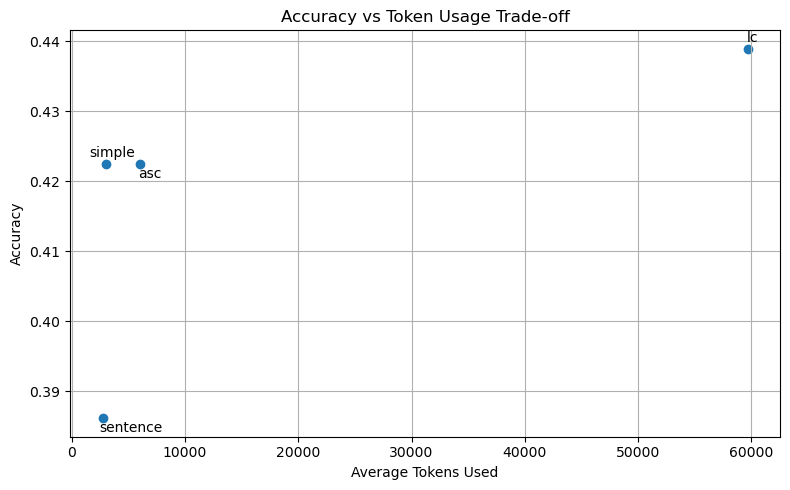

In [17]:
summary_df["tokens_per_accuracy"] = summary_df["avg_tokens"] / summary_df["accuracy"]
summary_df = summary_df.sort_values(by="tokens_per_accuracy")

!conda install matplotlib -y
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(summary_df["avg_tokens"], summary_df["accuracy"])

# 添加偏移坐标防止重叠
offsets = {
    "simple": (-1500, 0.001),
    "sentence": (-300, -0.002),
    "asc": (-110, -0.002),
    "lc": (-110, 0.001)
}

for method in summary_df.index:
    x = summary_df.loc[method, "avg_tokens"]
    y = summary_df.loc[method, "accuracy"]
    dx, dy = offsets.get(method, (0, 0))  # 默认偏移为0
    plt.text(x + dx, y + dy, method, fontsize=10)

plt.xlabel("Average Tokens Used")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Token Usage Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()


### Correlation Analysis


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


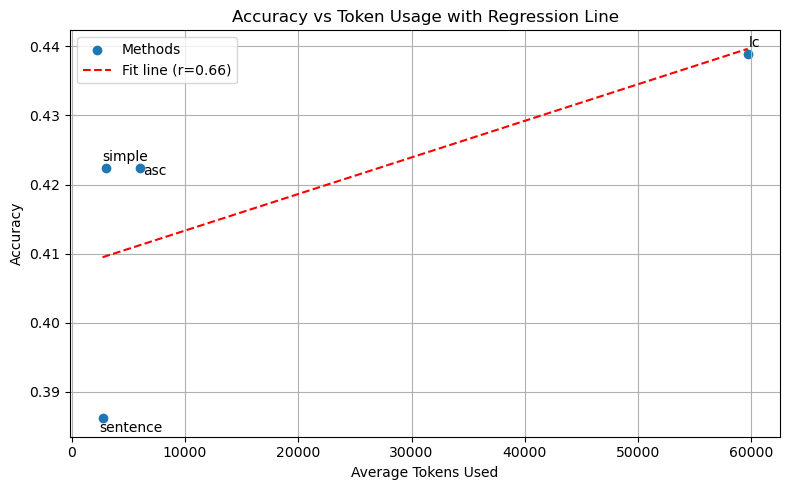

In [18]:
# Linear regression
x = summary_df["avg_tokens"]
y = summary_df["accuracy"]
methods = summary_df.index.tolist()
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label="Methods")
plt.plot(x, line, color="red", linestyle="--", label=f"Fit line (r={r_value:.2f})")

# Label placement with offsets
offsets = {
    "simple": (-300, 0.001),
    "sentence": (-300, -0.002),
    "asc": (300, -0.001),
    "lc": (100, 0.001)
}
for method in methods:
    dx, dy = offsets.get(method, (0, 0))
    plt.text(summary_df.loc[method, "avg_tokens"] + dx,
             summary_df.loc[method, "accuracy"] + dy,
             method, fontsize=10)

plt.xlabel("Average Tokens Used")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Token Usage with Regression Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [115]:
from scipy.stats import pearsonr

r, p = pearsonr(summary_df["avg_tokens"], summary_df["accuracy"])
print(f"Pearson correlation: r = {r:.4f}, p = {p:.4f}")

Pearson correlation: r = 0.6636, p = 0.3364


We observe a moderate positive correlation between average token usage and accuracy across the four methods (Pearson r = 0.66), suggesting that longer contexts may improve accuracy.
However, the relationship is not statistically significant (p = 0.34), likely due to the small number of methods, and thus should be interpreted cautiously.

The long-context (lc) method consumes significantly more tokens, while achieving only a marginal improvement in accuracy.

The sentence-based method uses fewer tokens but suffers from noticeably lower accuracy.

Both the simple and asc methods strike a more favourable balance between token usage and accuracy, representing a more efficient trade-off.